# A simple ripple carry adder on the QPU

In this notebook we implement a "simple" reversible binary adder. It is based on

*A new quantum ripple-carry addition circuit*, by 
Cuccaro, Draper, Kutin, and Moulton. See
https://arxiv.org/abs/quant-ph/0410184v1 .

The whole circuit is classical in the sense that we start and end in computational basis states and all gates simply perform classical not, controlled not, or doublely controled not.

In [1]:
import numpy as np
from pyquil.quil import Program
from pyquil.quilbase import Pragma 
from pyquil.gates import *
import pyquil.api as api
from pyquil.api import get_qc, get_benchmarker
from forest_qcvv.benchmarks.classical_logic_circuits.classical_reversible_logic_primitives import *
from scipy.spatial.distance import hamming
from scipy.special import comb
import time
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# noiseless QVM
#qc = get_qc("9q-generic-qvm", as_qvm=True, noisy=False)

# noisy QVM
qc = get_qc("9q-generic", as_qvm=True, noisy=True)

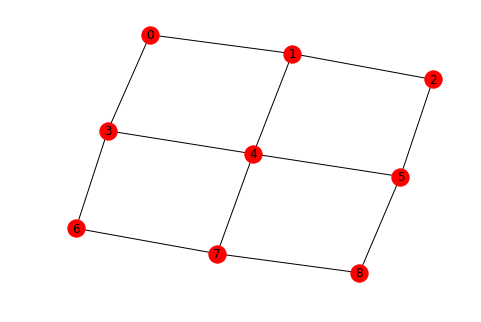

In [4]:
nx.draw(qc.qubit_topology(),with_labels=True)

In [5]:
num_of_qubits = len(qc.qubits())

In [9]:
def average_adder_result_over_input_strings(bin_str,num_of_qubits):
    """
    Find hamming weight distribution of errors relative to correct
    answer averaged over input strings.
    
    :param bin_str: a list of lists that contains all binary strings of length 2n, the
    adder adds who strings of length n.
    :returns wt: hamming weights from QPU or QVM
    """
    
    # loop over all binary strings of length "n"
    for binstr_idx in bin_str:
        # split the binary number into two numbers and store in a tuple
        # These are the binary numbers the user wants to add.
        # They are written from (MSB .... LSB) = (a_n, ..., a_1, a_0)
        num_a = tuple(binstr_idx[0:n])
        num_b = tuple(binstr_idx[n:2*n])

        # convert to string
        string_a = "".join([str(x) for x in num_a])
        string_b = "".join([str(x) for x in num_b])

        # add the numbers
        ans_str= int(string_b,2)+int(string_a,2)

        # convert back to a binary list of the right length
        desired_answer = [int(x) for x in format(ans_str,'0'+str(2*n-(n-1))+'b')]

        # do a check on the numbers
        check_binary_number_length(num_a,num_b,num_of_qubits)

        # create the qubit labels  
        qbit_labels = get_qubit_labels(num_a)

        # state prep. program.  Take the binary numbers and prepare the corresponing state  
        state_prep_prog, register_a, register_b, carry_ancilla, z_ancilla = prepare_binary_numbers(num_a,num_b,qbit_labels)

        # program to add numbers
        add_binary_numbers = adder(register_a, register_b, carry_ancilla, z_ancilla)
        
        # Run it on the QPU or QVM
        qpustart = time.time()
        result = qc.run_and_measure(state_prep_prog + add_binary_numbers, trials=num_trials)
        qpuend = time.time()
        print('runtime: ' + str(qpuend - qpustart))
        result = np.vstack(result[q] for q in qbit_labels).T

        #Figure out where the results are stored
        sumk = []
        for result_idx in qbit_labels[1:-1]:
            if result_idx in register_b:
                sumk.insert(0,qbit_labels.index(result_idx))
        #make sure you append the carry bit silly!!
        sumk.insert(0,len(qbit_labels)-1)

        # get the answer   
        answer = []
        for trials_idx in range(num_trials):
            temp =[]
            for ans_idx in sumk:
                temp.append(result[trials_idx][ans_idx])
            answer.append(temp)
            
        # find hamming weight between desired_answer (correct) and QPU / QVM result
        count = 0
        for i in range(len(answer)):
            wt[binstr_idx,i]= (n)*hamming(desired_answer, answer[i])
            if desired_answer == answer[i]:
                count +=1
        # Sloppy accounting for the case where the number of
        # sucesses equals zero
        if count == 0:
            count +=1
        print('Pr(suc) = '+ str(count/num_trials))
    return wt

**time to get some results**

runtime: 0.8547830581665039
Pr(suc) = 0.775
runtime: 0.7441396713256836
Pr(suc) = 0.775
runtime: 0.7584469318389893
Pr(suc) = 0.7
runtime: 0.7416961193084717
Pr(suc) = 0.675


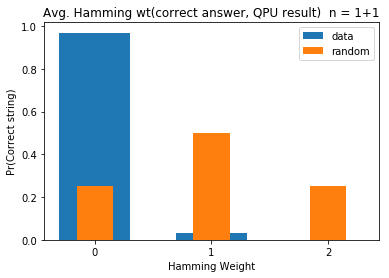

runtime: 1.9666249752044678
Pr(suc) = 0.6
runtime: 1.937204122543335
Pr(suc) = 0.475
runtime: 1.9344758987426758
Pr(suc) = 0.5
runtime: 1.8510799407958984
Pr(suc) = 0.45
runtime: 1.9326868057250977
Pr(suc) = 0.575
runtime: 1.9014379978179932
Pr(suc) = 0.575
runtime: 1.8887591361999512
Pr(suc) = 0.525
runtime: 1.8792319297790527
Pr(suc) = 0.475
runtime: 1.8940598964691162
Pr(suc) = 0.425
runtime: 1.8781909942626953
Pr(suc) = 0.425
runtime: 1.7899940013885498
Pr(suc) = 0.575
runtime: 1.8853130340576172
Pr(suc) = 0.4
runtime: 1.8556277751922607
Pr(suc) = 0.5
runtime: 1.797555923461914
Pr(suc) = 0.725
runtime: 1.8716142177581787
Pr(suc) = 0.625
runtime: 1.885699987411499
Pr(suc) = 0.45


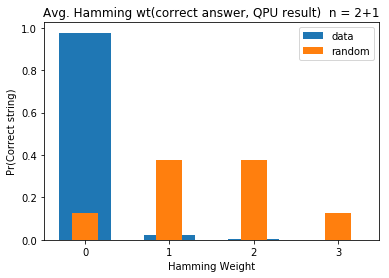

In [15]:
# If equal to 10,000  = 1% error
num_trials = 40 #000

avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for ndx in range(1,3):
    # length of binary string
    n=ndx
    
    bin_str = []
    bin_str = construct_all_possible_input_numbers(n)
    
    # find hamming weight distribution of errors relative to correct
    # answer averaged over all possible input strings
    wt = np.zeros((2**(2*n),num_trials))
    wt = average_adder_result_over_input_strings(bin_str,num_of_qubits)
    histy = construct_bit_flip_error_histogram(wt,n)
    hamming_wt = np.array([comb(n+1,x) for x in list(range(0,n+2))])
    hamming_dist = hamming_wt/sum(hamming_wt)

    # calculate statistics
    exp_average_hamming = np.average(histy,0)/num_trials
    avg_n.append(np.average(histy[0],0)/num_trials)
    med_n.append(np.median(histy[0],0)/num_trials)
    min_n.append(np.min(histy[0],0)/num_trials)
    max_n.append(np.max(histy[0],0)/num_trials)
    rand_n.append(hamming_dist[0])

    # some plotting
    weight_vec = list(np.arange(0,n+2))
    plt.bar(weight_vec,exp_average_hamming,width=0.61,align='center')
    plt.bar(weight_vec,hamming_dist,width=0.31,align='center')
    plt.xticks(weight_vec, list(range(0,n+2)))
    plt.xlabel('Hamming Weight')
    plt.ylabel('Pr(Correct string)' )
    plt.legend(['data','random'])
    plt.title('Avg. Hamming wt(correct answer, QPU result)' '  n = ' + str(n) + '+' +str(1))
    name = 'hamm_n_equal_' + str(n)
    plt.savefig(name+'.pdf', bbox_inches='tight')
    plt.show()